# 01-BU

To find trends in IT job market and find the skills that are in demand,especiaaly AI's impact.

# 02-DU

## Load Dataset

In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructType, StructField, Row, IntegerType, ArrayType
from pyspark.sql.functions import col, split, trim, array, explode, lit, when, udf
from collections import Counter
import re

spark = SparkSession.builder.appName('Iteration_4').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 23:36:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [20]:
# Let's read in the data. Note that it's in the format of csv.
df01 = spark.read.csv('Datasets/job_postings.csv', header=True, inferSchema=True)
df02 = spark.read.csv('Datasets/job_skills.csv', header=True, inferSchema=True)
df01_count = df01.count()
df02_count = df02.count()
(df01_count,df02_count)

(12218, 12217)

## Use pandas to try again

In [3]:
# Read the data
df01 = spark.read.csv('Datasets/job_postings_clean.csv', header=True, inferSchema=True)
df02 = spark.read.csv('Datasets/job_skills.csv', header=True, inferSchema=True)

# Check row counts of the dataframes
df01_count = df01.count()
df02_count = df02.count()
print(f"job_postings_clean.csv count: {df01_count}")
print(f"job_skills.csv count: {df02_count}")

# View data
df01.describe().show()
df02.describe().show()

# Compare row counts of the two dataframes
if df01_count != df02_count:
    print("DataFrames have a different number of rows, cannot verify job_link equality.")
else:
    # Compare 'job_link' column
    job_link_match_count = df01.join(df02, df01.job_link == df02.job_link).count()
    if job_link_match_count == df01_count:
        # If 'job_link' columns are the same, merge the two dataframes
        merged_df = df01.join(df02, 'job_link')
        print("DataFrames merged successfully.")
    else:
        print("DataFrames' job_link columns are not the same, cannot merge.")

# View the merged data schema
merged_df.printSchema()

# Describe the merged data and convert to Pandas DataFrame for better display
desc_df = merged_df.describe().toPandas().transpose()

# Set the first row as header
desc_df.columns = desc_df.iloc[0]
desc_df = desc_df[1:]

# Round the numerical data for better readability
desc_df = desc_df.round(2)

# Display the transposed and rounded description
print(desc_df)

# Class distribution
merged_df.groupBy('job_level').count().show()
merged_df.groupBy('job_type').count().show()

job_postings_clean.csv count: 12217
job_skills.csv count: 12217


+-------+--------------------+--------------------+------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+-----------+--------------+----------------+----------+--------+
|summary|            job_link| last_processed_time| last_status|got_summary|got_ner|is_being_worked|           job_title|             company|        job_location|first_seen|search_city|search_country| search_position| job_level|job_type|
+-------+--------------------+--------------------+------------+-----------+-------+---------------+--------------------+--------------------+--------------------+----------+-----------+--------------+----------------+----------+--------+
|  count|               12217|               12217|       12217|      12217|  12217|          12217|               12217|               12217|               12216|     12217|      12217|         12217|           12217|     12217|   12217|
|   mean|                null|              

summary              count   mean stddev  \
job_link             12217   None   None   
last_processed_time  12217   None   None   
last_status          12217   None   None   
got_summary          12217   None   None   
got_ner              12217   None   None   
is_being_worked      12217   None   None   
job_title            12217   None   None   
company              12217  257.0    0.0   
job_location         12216   None   None   
first_seen           12217   None   None   
search_city          12217   None   None   
search_country       12217   None   None   
search_position      12217   None   None   
job_level            12217   None   None   
job_type             12217   None   None   
job_skills           12212   None   None   

summary                                                            min  \
job_link             https://au.linkedin.com/jobs/view/%F0%9F%8C%9F...   
last_processed_time                      2024-01-19 09:45:09.215838+00   
last_status                  

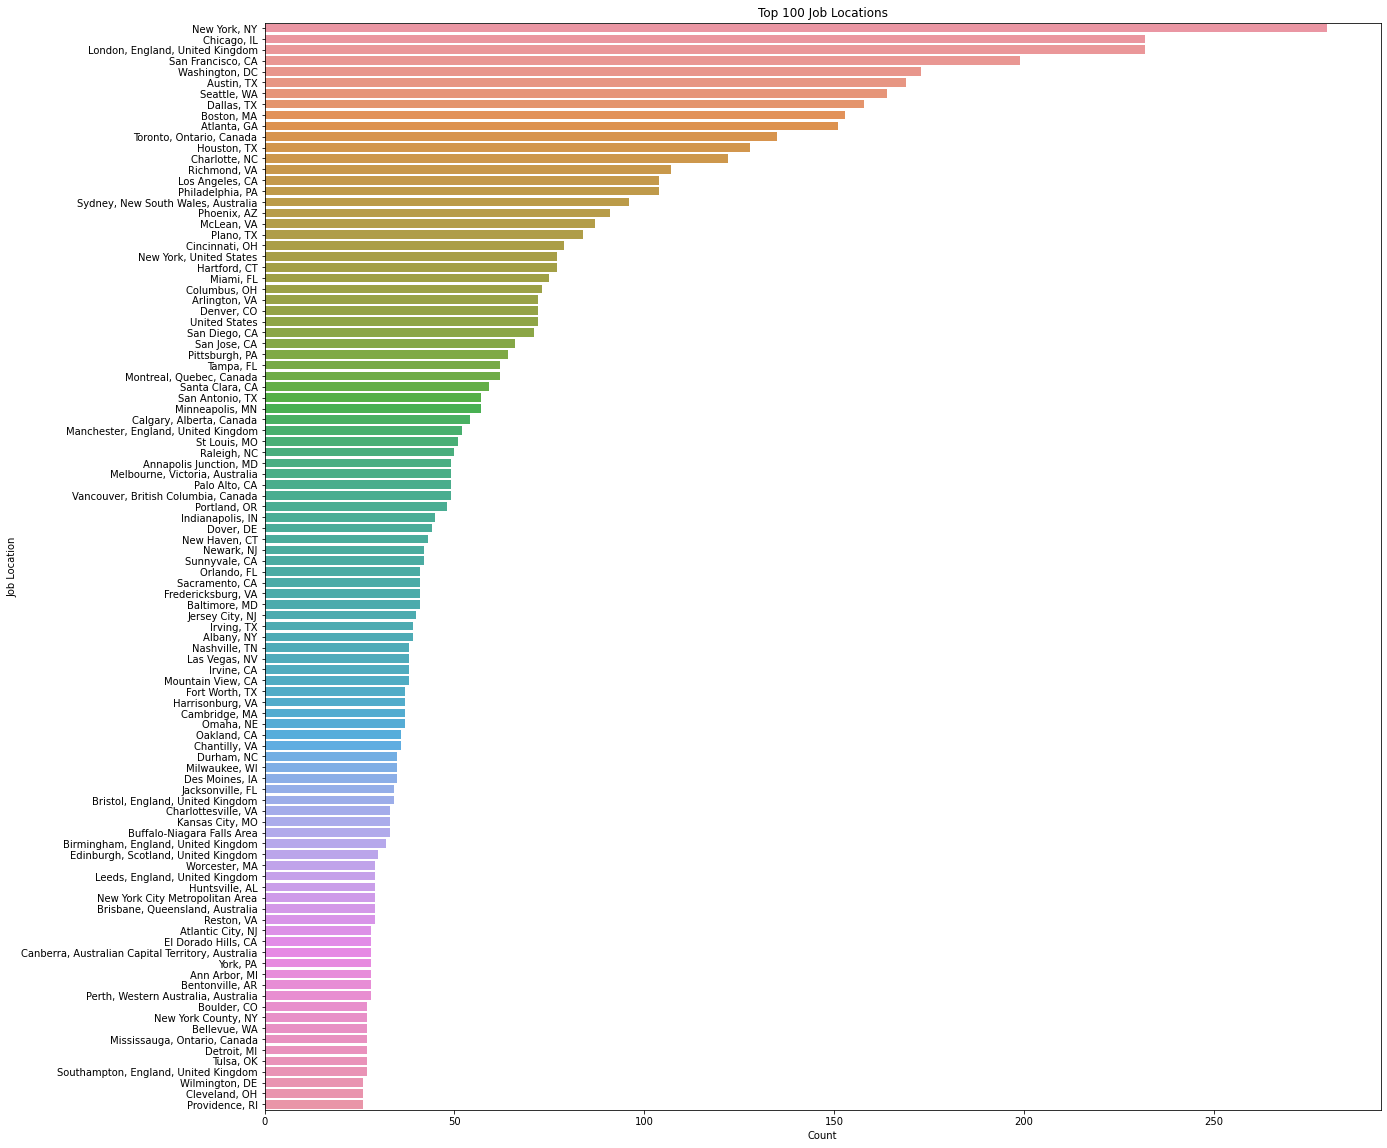

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pandas_df = merged_df.toPandas()

top_n = 100  
top_locations = pandas_df['job_location'].value_counts().nlargest(top_n).index
top_pandas_df = pandas_df[pandas_df['job_location'].isin(top_locations)]

plt.figure(figsize=(20, 20))
sns.countplot(y='job_location', data=top_pandas_df, order=top_pandas_df['job_location'].value_counts().index)
plt.title(f'Top {top_n} Job Locations')
plt.xlabel('Count')
plt.ylabel('Job Location')
plt.show()

# 03-DP

In [5]:
# Delete the null values in the column 'job_skills' and 'job_location'
merged_df = merged_df.dropna(subset=['job_skills', 'job_location'])
print(f"Shape after dropping null values: ({merged_df.count()}, {len(merged_df.columns)})")
merged_df.printSchema()

# Drop the columns that are not needed
columns_to_drop = ['last_processed_time', 'last_status', 'job_link', 'got_summary', 'got_ner',
                   'is_being_worked', 'company', 'first_seen', 'search_city', 'search_position', 'job_type']
filtered_df = merged_df.drop(*columns_to_drop)

# View the schema and describe the filtered data
filtered_df.printSchema()
filtered_df.describe().show()

Shape after dropping null values: (12211, 16)
root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- last_status: string (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)
 |-- job_skills: string (nullable = true)

root
 |-- job_title: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_skills: string (nullable = true)



+-------+--------------------+--------------------+--------------+----------+--------------------+
|summary|           job_title|        job_location|search_country| job_level|          job_skills|
+-------+--------------------+--------------------+--------------+----------+--------------------+
|  count|               12211|               12211|         12211|     12211|               12211|
|   mean|                null|                null|          null|      null|                null|
| stddev|                null|                null|          null|      null|                null|
|    min|"Sr Business Anal...|Abbots Salford, E...|     Australia| Associate|"AML/KYC verifica...|
|    max|🌟 Expression of ...|          Zwolle, LA| United States|Mid senior|x86 platform, CPU...|
+-------+--------------------+--------------------+--------------+----------+--------------------+



In [6]:
# Define the UDF to split job_location
def split_location(location):
    if location is None:
        return (None, None, None)

    parts = [part.strip() for part in location.split(',')]
    city = state = country = None

    known_countries = ["United States", "United Kingdom", "Canada",
                       "Australia", "India", "Germany", "France", "Italy", "Spain", "Mexico"]
    us_states = {
        'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
        'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
        'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
        'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
        'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
        'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
        'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
        'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
        'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
        'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'Washington'
    }
    # Create a reverse map from full state name to abbreviation
    state_abbrev = {v: k for k, v in us_states.items()}

    # If there is only one part
    if len(parts) == 1:
        if parts[0] in known_countries:
            country = parts[0]
        else:
            state = parts[0]  # Translate to state if not in known countries
    elif len(parts) == 2:
        if parts[1] in known_countries:
            city = parts[0]
            country = parts[1]
            if city in state_abbrev and country == "United States":
                state = state_abbrev[city]
                city = None
            else:
                state = city
                city = None
        else:
            city, state = parts
            if state in us_states.keys():  # If the state name is the abbreviation of the US state
                country = "United States"  # Country name to United States
    elif len(parts) == 3:
        city, state, country = parts
        if state in state_abbrev:  # If state is full name
            state = state_abbrev[state]  # To abbreviation

    return (city, state, country)

split_location_udf = udf(split_location, StructType([
    StructField("City", StringType(), True),
    StructField("State", StringType(), True),
    StructField("Country", StringType(), True)
]))

# Apply the UDF to split job_location
filtered_df = filtered_df.withColumn("location_split", split_location_udf(col("job_location")))

# Extract the columns from the struct
filtered_df = filtered_df.withColumn("City", col("location_split.city")) \
                         .withColumn("State", col("location_split.state")) \
                         .withColumn("Country", col("location_split.country")) \
                         .drop("location_split")

# View the schema and describe the filtered data
filtered_df.printSchema()
filtered_df.head()

root
 |-- job_title: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_skills: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)



Row(job_title='Senior Machine Learning Engineer', job_location='New Haven, CT', search_country='United States', job_level='Mid senior', job_skills='Machine Learning, Programming, Python, Scala, Java, Data Engineering, Distributed Computing, Statistical Modeling, Optimization, Data Pipelines, Cloud Computing, DevOps, Software Development, Data Gathering, Data Preparation, Data Visualization, Machine Learning Frameworks, scikitlearn, PyTorch, Dask, Spark, TensorFlow, Distributed File Systems, Multi node Database Paradigms, Open Source ML Software, Responsible AI, Explainable AI', City='New Haven', State='CT', Country='United States')

In [7]:
from pyspark.sql.functions import col, when, split, explode, array_remove, array_distinct, array_contains, udf
from IPython.display import display, HTML
# Define the skill mapping

skill_mapping = {
    r"(?i)\bgo\b|(?i)\bgolang\b": "Go/Golang",
    r"(?i)\bruby on rails\b": "Ruby",
    r"(?i)\b(ai|llms|artificial intelligence|generative ai|natural language processing|ml|reinforcement learning|machine learning|deep learning|nlp)\b": "ML/AI",
    r"(?i)\bproblem solving\b": "ProblemSolving",
    r"(?i)\bmicrosoft (office|excel)\b|\bmicrosoft\b|\boffice\b|\bexcel\b|\bpowerpoint\b": "MicrosoftOffice",
    r"(?i)\b(cloud|azure|aws|s3|ec2|gcp)\b": "CloudComputing",
    r"(?i)\bcommunication\b": "Communication",
    r"(?i)\b(software|programming|developer)\b": "SoftwareDevelopment",
    r"(?i)\b(data science|data scientist)\b": "DataScience",
    r"(?i)\b(data analysis|data analytics|data_analysis)\b": "DataAnalysis",
    r"(?i)\bjava\b(?!script)": "Java",  # Exclude JavaScript
    r"(?i)\b(javascript|typescript)\b": "JavaScript/TypeScript",
    r"(?i)\b(sql|database|mongodb|postgres|pl/sql|posqldatabases|postgresql|mysql|sql server|microsoft sql server|tsql|no sql databases|nosql)\b": "Database"
}

# Given programming languages list
programming_languages = [
    "Python", "C++", "Java", "C#", "JavaScript", "SQL", "Go", "Golang",
    "Scratch", "Visual Basic", "Assembly language", "PHP", "MATLAB",
    "Fortran", "Delphi/Object Pascal", "Swift", "Rust", "Ruby",
    "Kotlin", "COBOL"
]
# Function to replace skills based on the mapping and remove spaces
def replace_skills(skills):
    if skills is None:
        return []
    new_skills = []
    for skill in skills:
        skill = skill.strip().lower()
        replaced = False
        for pattern, replacement in skill_mapping.items():
            if re.search(pattern, skill):
                new_skills.append(replacement.replace(" ", ""))
                replaced = True
                break
        if not replaced:
            new_skills.append(skill.replace(" ", "").capitalize())
    return list(set(new_skills))  # Remove duplicates

replace_skills_udf = udf(replace_skills, ArrayType(StringType()))

# Split job_skills by comma
filtered_df = filtered_df.withColumn("job_skills_split", split(col("Job_Skills"), ","))

# Replace skills in job_skills_split
filtered_df = filtered_df.withColumn("job_skills_split", replace_skills_udf(col("job_skills_split")))

# Explode job_skills_split to get distinct skills and their counts
exploded_df = filtered_df.withColumn("skill", explode(col("job_skills_split")))
skills_count_df = exploded_df.groupBy("skill").count().orderBy(col("count").desc())
skills_count_df.show()

# Collect all skills and their counts
all_skills_sorted = [(row["skill"], row["count"]) for row in skills_count_df.collect()]

# Normalize the programming languages list
programming_languages_normalized = [skill_mapping.get(lang.lower(), lang.replace(" ", "").capitalize()) for lang in programming_languages]

# Prepare headers_with_rankings
headers_with_rankings = [f"{i + 1}_{skill}" for i, (skill, _) in enumerate(all_skills_sorted[:250])]

# Find programming languages not in the top 250
languages_not_in_top_250 = [lang for lang in programming_languages_normalized if lang not in [
    skill for skill, _ in all_skills_sorted[:250]]]

# Add ranks for languages not in the top 250
for lang in languages_not_in_top_250:
    rank = next((i + 1 for i, (skill, _) in enumerate(all_skills_sorted) if skill == lang), None)
    if rank is not None:  # Only include programming languages with a rank
        headers_with_rankings.append(f"{rank}_{lang}")

# Add new columns for each skill with ranking and set value to 1 if the skill is present
for header in headers_with_rankings:
    skill_name = header.split('_', 1)[1]
    filtered_df = filtered_df.withColumn(header, when(array_contains(col("job_skills_split"), skill_name), 1).otherwise(0))

# Remove the temporary job_skills_split column
filtered_df = filtered_df.drop("job_skills_split")

# Show the schema and data
filtered_df.printSchema()

# Convert Spark DataFrame to Pandas DataFrame for prettier display
filtered_data_pd = filtered_df.toPandas()
display(HTML(filtered_data_pd.head().to_html()))
# Display the summary statistics of the final data
display(HTML(filtered_data_pd.describe(include='all').to_html()))

# Capitalize the first letter of the first three column names in the DataFrame
for i, col_name in enumerate(filtered_df.columns[:5]):
    filtered_df = filtered_df.withColumnRenamed(col_name, col_name.title())
# print("Capitalize")
filtered_df.printSchema()

/tmp/ipykernel_4126/1758600407.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_4126/1758600407.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_4126/1758600407.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_4126/1758600407.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11


+-------------------+-----+
|              skill|count|
+-------------------+-----+
|           Database| 6192|
|      Communication| 5322|
|             Python| 4753|
|       DataAnalysis| 4588|
|     CloudComputing| 4265|
|              ML/AI| 3362|
|SoftwareDevelopment| 3181|
|    MicrosoftOffice| 3063|
|  Datavisualization| 2267|
|        DataScience| 1832|
|  Projectmanagement| 1715|
|    Dataengineering| 1697|
|            Tableau| 1671|
|     ProblemSolving| 1538|
|                  R| 1527|
|       Datamodeling| 1498|
|               Java| 1461|
|     Datamanagement| 1457|
|            Powerbi| 1402|
|    Datawarehousing| 1378|
+-------------------+-----+
only showing top 20 rows



root
 |-- job_title: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_skills: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- 1_Database: integer (nullable = false)
 |-- 2_Communication: integer (nullable = false)
 |-- 3_Python: integer (nullable = false)
 |-- 4_DataAnalysis: integer (nullable = false)
 |-- 5_CloudComputing: integer (nullable = false)
 |-- 6_ML/AI: integer (nullable = false)
 |-- 7_SoftwareDevelopment: integer (nullable = false)
 |-- 8_MicrosoftOffice: integer (nullable = false)
 |-- 9_Datavisualization: integer (nullable = false)
 |-- 10_DataScience: integer (nullable = false)
 |-- 11_Projectmanagement: integer (nullable = false)
 |-- 12_Dataengineering: integer (nullable = false)
 |-- 13_Tableau: integer (nullable = false)
 |-- 14_ProblemSolving: integer (nulla

24/05/23 23:37:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/pytho

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

root
 |-- Job_Title: string (nullable = true)
 |-- Job_Location: string (nullable = true)
 |-- Search_Country: string (nullable = true)
 |-- Job_Level: string (nullable = true)
 |-- Job_Skills: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- 1_Database: integer (nullable = false)
 |-- 2_Communication: integer (nullable = false)
 |-- 3_Python: integer (nullable = false)
 |-- 4_DataAnalysis: integer (nullable = false)
 |-- 5_CloudComputing: integer (nullable = false)
 |-- 6_ML/AI: integer (nullable = false)
 |-- 7_SoftwareDevelopment: integer (nullable = false)
 |-- 8_MicrosoftOffice: integer (nullable = false)
 |-- 9_Datavisualization: integer (nullable = false)
 |-- 10_DataScience: integer (nullable = false)
 |-- 11_Projectmanagement: integer (nullable = false)
 |-- 12_Dataengineering: integer (nullable = false)
 |-- 13_Tableau: integer (nullable = false)
 |-- 14_ProblemSolving: integer (nulla

# 4-DT

## Creating New Job Roles Based on Keywords in Job_Title

root
 |-- Job_Level: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- 1_Database: integer (nullable = false)
 |-- 2_Communication: integer (nullable = false)
 |-- 3_Python: integer (nullable = false)
 |-- 4_DataAnalysis: integer (nullable = false)
 |-- 5_CloudComputing: integer (nullable = false)
 |-- 6_ML/AI: integer (nullable = false)
 |-- 7_SoftwareDevelopment: integer (nullable = false)
 |-- 8_MicrosoftOffice: integer (nullable = false)
 |-- 9_Datavisualization: integer (nullable = false)
 |-- 10_DataScience: integer (nullable = false)
 |-- 11_Projectmanagement: integer (nullable = false)
 |-- 12_Dataengineering: integer (nullable = false)
 |-- 13_Tableau: integer (nullable = false)
 |-- 14_ProblemSolving: integer (nullable = false)
 |-- 15_R: integer (nullable = false)
 |-- 16_Datamodeling: integer (nullable = false)
 |-- 17_Java: integer (nullable = false)
 |-- 18_Datamanagement: integer (nullable = false)
 |-- 19_Powerbi: 

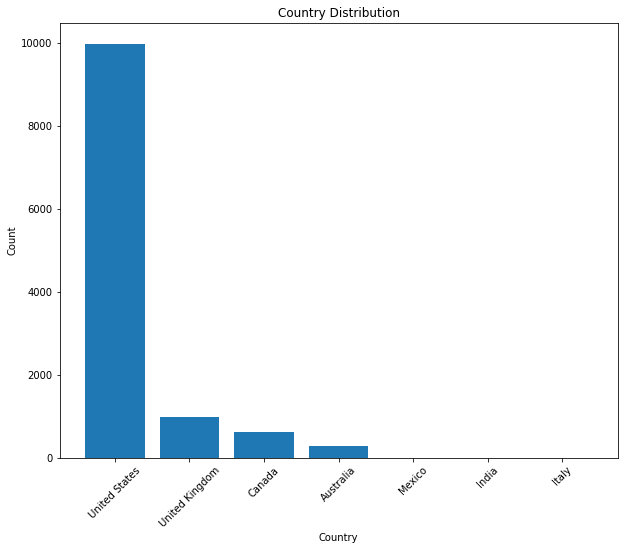

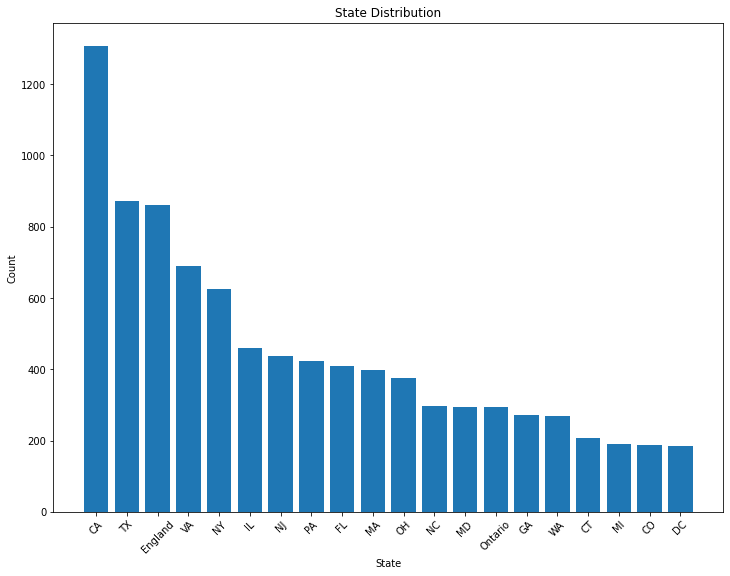

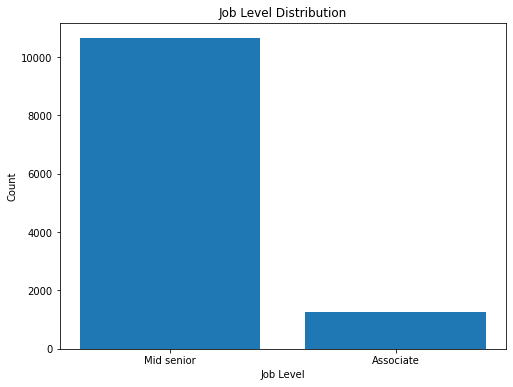

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

Number of rows where all six new columns are zeros: 977


/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

all_zero_rows_data table:


Shape of the data after removing rows: 10921, 269


Shape of the data after dropping 'all_zero' column: 10921, 268


/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, lower, regexp_replace, sum as spark_sum
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
from functools import reduce

# Job classification dictionary, each category contains related keywords
categories = {
    'Cloud': ['cloud', 'aws', 'azure', 'google cloud', 'cloud engineer', 'data center', 'cloud architect', 'datacenter','s3'],
    'Testing': ['test', 'tester', 'testing', 'quality assurance', 'qa', 'test engineer','unit testing'],
    'Development': ['developer', 'development', 'software engineer', 'programmer', 'solution architect', 'database developer',
                    'software', 'software development', "C++", "Java", "C#", "JavaScript/TypeScript", "Go/Golang", "Visual Basic",
                    "Assembly language", "PHP", "Delphi/Object Pascal", "Swift", "Rust", "Ruby",
                    "Kotlin", "COBOL"],
    'Data_science': ['data science', 'machine learning', 'ml', 'deep learning', 'ai', 'artificial intelligence', 'data scientist', 'analytics architect', 'data analytics', 'npl','Tensorflow'],
    'Data_analysis': ['data analyst', 'data analysis', 'business intelligence', 'data reporting', 'financial data', 'data warehouse', 'data mining', 'data architect','Powerbi','Tableau'],
    'Devops': ['devops engineer', 'site reliability', 'sre', 'automation engineer', 'infrastructure as code', 'ci/cd', 'release engineer','Devops']
}

for category in categories:
    filtered_df = filtered_df.withColumn(category, lit(0).cast(IntegerType()))

# Update keywords in job_title column
for category, keywords in categories.items():
    for keyword in keywords:
        filtered_df = filtered_df.withColumn(category, when(lower(col("Job_Title")).contains(keyword.lower()), 1).otherwise(col(category)))

# Update categories in other skills columns
for category, keywords in categories.items():
    for keyword in keywords:
        formatted_keyword = ''.join(word.capitalize() for word in keyword.split())
        column_pattern = f"_{formatted_keyword}".lower()
        matching_columns = [c for c in filtered_df.columns if column_pattern in c.lower()]
        for match_col in matching_columns:
            filtered_df = filtered_df.withColumn(category, when(col(match_col) == 1, 1).otherwise(col(category)))

# Drop rows with null values in Job_Skills, State, or Country columns
filtered_df = filtered_df.dropna(subset=['Job_Skills', 'State', 'Country'])

# Drop unnecessary columns
columns_to_drop = ['Job_Title', 'Search_Country', 'Job_Location', 'City', 'Job_Skills']
filtered_df = filtered_df.drop(*columns_to_drop)

# Show the number of non-null values and data types of each column
filtered_df.printSchema()

# Calculate the distribution of countries
country_counts = filtered_df.groupBy("Country").count().orderBy("count", ascending=False).toPandas()

# Display bar chart
plt.figure(figsize=(10, 8))
plt.bar(country_counts['Country'], country_counts['count'])
plt.title('Country Distribution')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Calculate the distribution of states
state_counts = filtered_df.groupBy("State").count().orderBy("count", ascending=False).toPandas()

# Display bar chart
plt.figure(figsize=(12, 9))
plt.bar(state_counts['State'][:20], state_counts['count'][:20])  # Only the first 20 states are displayed
plt.title('State Distribution')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Calculate the distribution of job levels
job_level_counts = filtered_df.groupBy("Job_Level").count().orderBy("count", ascending=False).toPandas()

# Display bar chart
plt.figure(figsize=(8, 6))
plt.bar(job_level_counts['Job_Level'], job_level_counts['count'])
plt.title('Job Level Distribution')
plt.xlabel('Job Level')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Convert Spark DataFrame to Pandas DataFrame for prettier display
filtered_data_pd = filtered_df.toPandas()

# Display the summary statistics of the final data
display(HTML(filtered_data_pd.describe(include='all').to_html()))

# Check if the values of the six new columns are all zeros in each row
new_columns = ['Cloud', 'Testing', 'Development', 'Data_science', 'Data_analysis', 'Devops']
filtered_df = filtered_df.withColumn('all_zero', (reduce(lambda a, b: a + b, [col(col_name) for col_name in new_columns]) == 0).cast("int"))

# Count the number of rows where all six new columns are zeros
all_zero_rows = filtered_df.filter(col('all_zero') == 1).count()
print(f"Number of rows where all six new columns are zeros: {all_zero_rows}")

# Display the first few rows where all six new columns are zeros
all_zero_rows_data = filtered_df.filter(col('all_zero') == 1)

# Convert to Pandas DataFrame for display
all_zero_rows_data_pd = all_zero_rows_data.toPandas()
# display(HTML(all_zero_rows_data_pd.to_html(index=False)))
print("all_zero_rows_data table:")
display(HTML(all_zero_rows_data_pd.describe(include='all').to_html()))
# Remove rows where all six new columns are zeros
filtered_df = filtered_df.filter(col('all_zero') == 0)

# Verify the removal of rows
print(f"Shape of the data after removing rows: {filtered_df.count()}, {len(filtered_df.columns)}")

# Drop the 'all_zero' column as it is no longer needed
final_filtered_data = filtered_df.drop("all_zero")

# Display the shape of the data to verify rows have been removed
print(f"Shape of the data after dropping 'all_zero' column: {final_filtered_data.count()}, {len(final_filtered_data.columns)}")

# Convert Spark DataFrame to Pandas DataFrame for prettier display
final_filtered_data_pd = final_filtered_data.toPandas()

# Display the summary statistics of the final data
display(HTML(final_filtered_data_pd.describe(include='all').to_html()))

In [9]:
display(final_filtered_data_pd.describe())
# Remove useless columns
filterd_spark_df = final_filtered_data.drop('2_Communication', '8_MicrosoftOffice', '11_Projectmanagement',
    '14_ProblemSolving', '22_Teamwork', '25_Attentiontodetail', '26_Collaboration', '31_Businessintelligence',
    '32_Problemsolving', '38_Leadership', '41_Reporting', '44_Troubleshooting', '48_Timemanagement', 
    '55_Interpersonalskills','59_Criticalthinking', '61_Organizationalskills', '65_Problemsolvingskills',
    '66_Presentationskills', '73_Customerservice','77_Mentoring', '81_Riskmanagement', '85_Multitasking', 
    '90_Qualitycontrol','91_Research','94_Adaptability', '96_Flexibility','99_Decisionmaking', '100_Businessanalysis',
    '114_Prioritization', '115_Compliance', '117_Changemanagement', '119_Teamleadership','124_Qualityassurance',
    '127_Training','128_Analyticalthinking', '130_Innovation', '133_Security','135_Technicalwriting','137_Finance',
    '139_Decisionmaking', '141_Performancetuning','142_Businessacumen','147_Economics', '159_Experimentation', 
    '163_Processimprovement', '164_Organization', '165_Optimization', '171_Networking', '175_Accuracy', 
    '176_Productmanagement','178_Crossfunctionalcollaboration','183_Forecasting', '190_Medicaltechnology', 
    '192_Windows', '193_Presentation', '194_Design','196_Equalopportunityemployer', '198_Diversity', 
    '206_Teammanagement','208_Chemistry','209_Businessrequirements','212_Scheduling','214_Electricalengineering',
    '215_Businessanalytics','223_Requirementsgathering', '224_Planning', '225_Travel', '226_Sharepoint', 
    '227_Inclusion', '228_Teamcollaboration', '229_Healthcare','240_Salesforce','241_Leadershipskills',
    '246_Confidentiality','247_Independentwork','248_Peoplemanagement')

# Check null values
print("filterd_spark_df's count:",filterd_spark_df.count())
df_no_null = filterd_spark_df.na.drop()
print("After droping:",df_no_null.count())

# Convert Spark DataFrame to Pandas DataFrame
pd_dropped_spark_df = filterd_spark_df.toPandas()

display(pd_dropped_spark_df.describe())

1_Database  2_Communication      3_Python  4_DataAnalysis  \
count  10921.000000     10921.000000  10921.000000    10921.000000   
mean       0.520740         0.431920      0.416354        0.409578   
std        0.499593         0.495366      0.492976        0.491778   
min        0.000000         0.000000      0.000000        0.000000   
25%        0.000000         0.000000      0.000000        0.000000   
50%        1.000000         0.000000      0.000000        0.000000   
75%        1.000000         1.000000      1.000000        1.000000   
max        1.000000         1.000000      1.000000        1.000000   

       5_CloudComputing       6_ML/AI  7_SoftwareDevelopment  \
count       10921.00000  10921.000000           10921.000000   
mean            0.37872      0.297866               0.282209   
std             0.48509      0.457341               0.450095   
min             0.00000      0.000000               0.000000   
25%             0.00000      0.000000               0.000000   
50%             0.00000      0.000000               0.000000   
75%             1.00000      1.000000               1.000000   
max             1.00000      1.000000               1.000000   

       8_MicrosoftOffice  9_Datavisualization  10_DataScience  ...  \
count       10921.000000         10921.000000    10921.000000  ...   
mean            0.245124             0.201355        0.162622  ...   
std             0.430180             0.401031        0.369038  ...   
min             0.000000             0.000000        0.000000  ...   
25%             0.000000             0.000000        0.000000  ...   
50%             0.000000             0.000000        0.000000  ...   
75%             0.000000             0.000000        0.000000  ...   
max             1.000000             1.000000        1.000000  ...   

          2219_Rust      513_Ruby    991_Kotlin    1560_Cobol         Cloud  \
count  10921.000000  10921.000000  10921.000000  10921.000000  10921.000000   
mean       0.001099      0.005677      0.002839      0.001465      0.437506   
std        0.033131      0.075136      0.053205      0.038250      0.496102   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            Testing   Development  Data_science  Data_analysis        Devops  
count  10921.000000  10921.000000  10921.000000   10921.000000  10921.000000  
mean       0.067302      0.417636      0.495284       0.556268      0.060526  
std        0.250555      0.493192      0.500001       0.496847      0.238469  
min        0.000000      0.000000      0.000000       0.000000      0.000000  
25%        0.000000      0.000000      0.000000       0.000000      0.000000  
50%        0.000000      0.000000      0.000000       1.000000      0.000000  
75%        0.000000      1.000000      1.000000       1.000000      0.000000  
max        1.000000      1.000000      1.000000       1.000000      1.000000  

[8 rows x 265 columns]

filterd_spark_df's count: 10921


After droping: 10921


/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

1_Database      3_Python  4_DataAnalysis  5_CloudComputing  \
count  10921.000000  10921.000000    10921.000000       10921.00000   
mean       0.520740      0.416354        0.409578           0.37872   
std        0.499593      0.492976        0.491778           0.48509   
min        0.000000      0.000000        0.000000           0.00000   
25%        0.000000      0.000000        0.000000           0.00000   
50%        1.000000      0.000000        0.000000           0.00000   
75%        1.000000      1.000000        1.000000           1.00000   
max        1.000000      1.000000        1.000000           1.00000   

            6_ML/AI  7_SoftwareDevelopment  9_Datavisualization  \
count  10921.000000           10921.000000         10921.000000   
mean       0.297866               0.282209             0.201355   
std        0.457341               0.450095             0.401031   
min        0.000000               0.000000             0.000000   
25%        0.000000               0.000000             0.000000   
50%        0.000000               0.000000             0.000000   
75%        1.000000               1.000000             0.000000   
max        1.000000               1.000000             1.000000   

       10_DataScience  12_Dataengineering    13_Tableau  ...     2219_Rust  \
count    10921.000000        10921.000000  10921.000000  ...  10921.000000   
mean         0.162622            0.148246      0.149803  ...      0.001099   
std          0.369038            0.355360      0.356895  ...      0.033131   
min          0.000000            0.000000      0.000000  ...      0.000000   
25%          0.000000            0.000000      0.000000  ...      0.000000   
50%          0.000000            0.000000      0.000000  ...      0.000000   
75%          0.000000            0.000000      0.000000  ...      0.000000   
max          1.000000            1.000000      1.000000  ...      1.000000   

           513_Ruby    991_Kotlin    1560_Cobol         Cloud       Testing  \
count  10921.000000  10921.000000  10921.000000  10921.000000  10921.000000   
mean       0.005677      0.002839      0.001465      0.437506      0.067302   
std        0.075136      0.053205      0.038250      0.496102      0.250555   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      1.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        Development  Data_science  Data_analysis        Devops  
count  10921.000000  10921.000000   10921.000000  10921.000000  
mean       0.417636      0.495284       0.556268      0.060526  
std        0.493192      0.500001       0.496847      0.238469  
min        0.000000      0.000000       0.000000      0.000000  
25%        0.000000      0.000000       0.000000      0.000000  
50%        0.000000      0.000000       1.000000      0.000000  
75%        1.000000      1.000000       1.000000      0.000000  
max        1.000000      1.000000       1.000000      1.000000  

[8 rows x 190 columns]

### Balance the target variable

7668 3253


/tmp/ipykernel_4126/1758600407.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_4126/1758600407.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

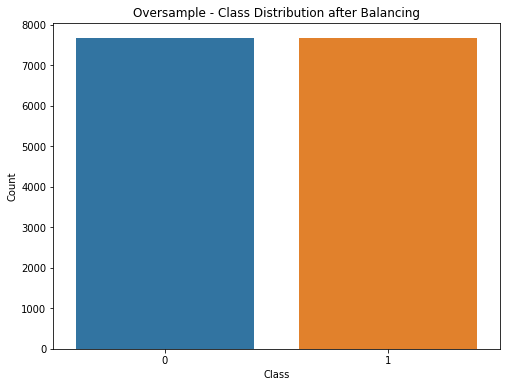

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

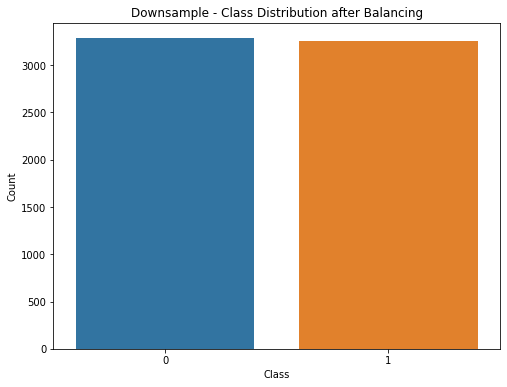

In [10]:
from pyspark.sql.functions import col, sum

# Separate majority and minority classes
majority_class = filterd_spark_df.filter(col("`6_ML/AI`") == 0)
minority_class = filterd_spark_df.filter(col("`6_ML/AI`") == 1)
print(majority_class.count(),minority_class.count())

# Downsample the majority class
majority_class_downsampled = majority_class.sample(False, float(minority_class.count()) / majority_class.count(), seed=42)

# Combine minority class with downsampled majority class
balanced_df_downsampled = majority_class_downsampled.union(minority_class)

# Upsample the minority class
minority_class_oversampled = minority_class.sample(True, float(majority_class.count()) / minority_class.count(), seed=42)

# Combine majority class with upsampled minority class
balanced_df_oversampled = majority_class.union(minority_class_oversampled)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert to Pandas DataFrame
## Oversample ##
balanced_pandas_df_oversampled = balanced_df_oversampled.toPandas()

# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(data=balanced_pandas_df_oversampled, x='6_ML/AI')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Oversample - Class Distribution after Balancing')
plt.show()

## Downsample ##
balanced_pandas_df_downsampled = balanced_df_downsampled.toPandas()

# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(data=balanced_pandas_df_downsampled, x='6_ML/AI')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Downsample - Class Distribution after Balancing')
plt.show()

## Creating Data Processing Pipelines

### Encoding categorical variables and assembling feature vectors 

In [11]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer

my_final_data = balanced_df_oversampled
# my_final_data = balanced_df_downsampled

# Ensure the target column is correctly referenced
target_column = "6_ML/AI"
if target_column in my_final_data.columns:
    balanced_df_oversampled = balanced_df_oversampled.withColumn("target", col(target_column))
else:
    raise ValueError(f"Column '{target_column}' does not exist in the DataFrame.")

# Create a pipeline for data processing
jobLevel_indexer = StringIndexer(inputCol='Job_Level', outputCol='JobLevelIndex', handleInvalid='keep')
jobLevel_encoder = OneHotEncoder(inputCol='JobLevelIndex', outputCol='JobLevelVec')

state_indexer = StringIndexer(inputCol='State', outputCol='StateIndex', handleInvalid='keep')
state_encoder = OneHotEncoder(inputCol='StateIndex', outputCol='StateVec')

country_indexer = StringIndexer(inputCol='Country', outputCol='CountryIndex', handleInvalid='keep')
country_encoder = OneHotEncoder(inputCol='CountryIndex', outputCol='CountryVec')

# Get all columns except the categorical and target columns for the feature assembler
categorical_columns = ['Job_Level', 'State', 'Country']
encoded_columns = ['JobLevelVec', 'StateVec', 'CountryVec']
# Correctly exclude the 'target' column and the original target column
feature_cols = [col for col in my_final_data.columns if col not in categorical_columns + encoded_columns + ['target', target_column]]

# Use VectorAssembler to combine all features into a single vector
assembler = VectorAssembler(inputCols=feature_cols + encoded_columns, outputCol="features")

# Transform the data.
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[
    jobLevel_indexer, jobLevel_encoder, 
    state_indexer, state_encoder, 
    country_indexer, country_encoder,
    assembler])
pipeline_model = pipeline.fit(my_final_data)
transformed_data = pipeline_model.transform(my_final_data)
transformed_data.select("features", target_column).show()
final_data = transformed_data.select("features", target_column)

+--------------------+-------+
|            features|6_ML/AI|
+--------------------+-------+
|(282,[0,2,3,10,14...|      0|
|(282,[0,1,2,3,7,1...|      0|
|(282,[0,1,11,20,2...|      0|
|(282,[3,4,18,44,9...|      0|
|(282,[0,2,8,9,13,...|      0|
|(282,[0,4,142,147...|      0|
|(282,[186,190,206...|      0|
|(282,[0,3,4,33,48...|      0|
|(282,[0,3,13,41,1...|      0|
|(282,[0,1,2,5,9,5...|      0|
|(282,[0,1,2,3,4,6...|      0|
|(282,[0,1,3,15,19...|      0|
|(282,[0,1,4,6,7,1...|      0|
|(282,[0,3,17,183,...|      0|
|(282,[3,4,12,110,...|      0|
|(282,[2,18,37,50,...|      0|
|(282,[0,1,2,11,22...|      0|
|(282,[0,2,8,187,1...|      0|
|(282,[0,4,5,13,16...|      0|
|(282,[3,4,44,93,1...|      0|
+--------------------+-------+
only showing top 20 rows



# 05 - DM ~ 06 - DA

## Build Models

In [12]:
# Train/test split 0.7/0.3
train_data, test_data = final_data.randomSplit([0.7,0.3])
# Train/test split 0.8/0.2
train_data_8, test_data_2 = final_data.randomSplit([0.8,0.2])

In [14]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, ClusteringEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import shap
import numpy as np
from pyspark.ml.clustering import KMeans
from sklearn.decomposition import PCA
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Initialize classifiers with increased maxBins
dtc = DecisionTreeClassifier(labelCol=target_column,
                             featuresCol="features",
                             predictionCol="prediction",
                             rawPredictionCol="rawPrediction",
                             maxBins=100)
rfc = RandomForestClassifier(labelCol=target_column,
                             featuresCol="features",
                             predictionCol="prediction",
                             rawPredictionCol="rawPrediction",
                             probabilityCol="probability",
                             numTrees=100, maxBins=100)
gbt = GBTClassifier(labelCol=target_column,
                    featuresCol="features",
                    predictionCol="prediction",
                    maxIter=10, maxBins=100)

In [15]:
dtc_fit_model = dtc.fit(train_data)
rfc_fit_model = rfc.fit(train_data)
gbt_fit_model = gbt.fit(train_data)

/tmp/ipykernel_1208/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_1208/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_1208/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_1208/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_1208/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_1208/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_1208/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_1208/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_1208/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_1208/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_1208/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_1208/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_1208/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_1208/2406088383.py:38: DeprecationWarning: Flags

In [16]:
# Transform test data. 
dtc_predictions = dtc_fit_model.transform(test_data)
rfc_predictions = rfc_fit_model.transform(test_data)
gbt_predictions = gbt_fit_model.transform(test_data)

In [17]:
# Evaluate the model using the binary classifer.

my_eval = BinaryClassificationEvaluator(labelCol=target_column)

In [18]:
# Evaluate using AUC (area under the curve), DTC, RFC, GBT. 
# AUC_lr = my_eval.evaluate(lr_predictions)
AUC_dtc = my_eval.evaluate(dtc_predictions)
AUC_rfc = my_eval.evaluate(rfc_predictions)
AUC_gbt = my_eval.evaluate(gbt_predictions)

# print(f"AUC for Logistic Regression: {AUC_lr}")
print(f"AUC for Decision Tree: {AUC_dtc}")
print(f"AUC for Random Forest: {AUC_rfc}")
print(f"AUC for GBT: {AUC_gbt}")

24/05/23 12:22:41 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/23 12:22:41 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


AUC for Decision Tree: 0.9404280670034365
AUC for Random Forest: 0.9548513566928731
AUC for GBT: 0.9711150281135283


## Try 80:20

In [19]:
# Build new model
dtc_fit_model_new = dtc.fit(train_data_8)
rfc_fit_model_new = rfc.fit(train_data_8)
gbt_fit_model_new = gbt.fit(train_data_8)

In [20]:
# Transform test data. 
dtc_predictions_new = dtc_fit_model_new.transform(test_data_2)
rfc_predictions_new = rfc_fit_model_new.transform(test_data_2)
gbt_predictions_new = gbt_fit_model_new.transform(test_data_2)

In [21]:
# Evaluate using AUC (area under the curve), DTC, RFC, GBT. 
# AUC_lr = my_eval.evaluate(lr_predictions)
AUC_dtc_new = my_eval.evaluate(dtc_predictions_new)
AUC_rfc_new = my_eval.evaluate(rfc_predictions_new)
AUC_gbt_new = my_eval.evaluate(gbt_predictions_new)

print(f"AUC for Decision Tree 80:20 : {AUC_dtc_new}")
print(f"AUC for Random Forest 80:20 : {AUC_rfc_new}")
print(f"AUC for GBT 80:20 : {AUC_gbt_new}")

AUC for Decision Tree 80:20 : 0.9319951286407799
AUC for Random Forest 80:20 : 0.9526556175226162
AUC for GBT 80:20 : 0.9659645596575944


In [22]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def evaluate_model(predictions, label_col):
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction")
    
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    
    return accuracy, f1, precision, recall

metrics_dtc = evaluate_model(dtc_predictions, target_column)
metrics_rfc = evaluate_model(rfc_predictions, target_column)
metrics_gbt = evaluate_model(gbt_predictions, target_column)

print(f"Decision Tree - Accuracy: {metrics_dtc[0]}, F1 Score: {metrics_dtc[1]}, Precision: {metrics_dtc[2]}, Recall: {metrics_dtc[3]}")
print(f"Random Forest - Accuracy: {metrics_rfc[0]}, F1 Score: {metrics_rfc[1]}, Precision: {metrics_rfc[2]}, Recall: {metrics_rfc[3]}")
print(f"GBT - Accuracy: {metrics_gbt[0]}, F1 Score: {metrics_gbt[1]}, Precision: {metrics_gbt[2]}, Recall: {metrics_gbt[3]}")

Decision Tree - Accuracy: 0.9021526418786693, F1 Score: 0.9021534745937948, Precision: 0.902188430191973, Recall: 0.9021526418786692
Random Forest - Accuracy: 0.8930202217873451, F1 Score: 0.8930133933476864, Precision: 0.8932528702100264, Recall: 0.8930202217873451
GBT - Accuracy: 0.9121548162644053, F1 Score: 0.9121470908139173, Precision: 0.9124499906614785, Recall: 0.9121548162644053


In [ ]:
metrics_dtc_new = evaluate_model(dtc_predictions_new, target_column)
metrics_rfc_new = evaluate_model(rfc_predictions_new, target_column)
metrics_gbt_new = evaluate_model(gbt_predictions_new, target_column)

print(f"Decision Tree - Accuracy 80:20: {metrics_dtc_new[0]}, F1 Score: {metrics_dtc_new[1]}, Precision: {metrics_dtc_new[2]}, Recall: {metrics_dtc_new[3]}")
print(f"Random Forest - Accuracy 80:20: {metrics_rfc_new[0]}, F1 Score: {metrics_rfc_new[1]}, Precision: {metrics_rfc_new[2]}, Recall: {metrics_rfc_new[3]}")
print(f"GBT - Accuracy 80:20: {metrics_gbt_new[0]}, F1 Score: {metrics_gbt_new[1]}, Precision: {metrics_gbt_new[2]}, Recall: {metrics_gbt_new[3]}")

## Cross Validate

In [13]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

dtc = DecisionTreeClassifier(labelCol=target_column, featuresCol="features", maxBins=100)
rfc = RandomForestClassifier(labelCol=target_column, featuresCol="features", numTrees=100, maxBins=100)
gbt = GBTClassifier(labelCol=target_column, featuresCol="features", maxIter=10, maxBins=100)

paramGrid_dtc = ParamGridBuilder() \
    .addGrid(dtc.maxDepth, [5, 10, 15]) \
    .addGrid(dtc.maxBins, [32, 64, 100]) \
    .build()

paramGrid_rfc = ParamGridBuilder() \
    .addGrid(rfc.numTrees, [50, 100, 150]) \
    .addGrid(rfc.maxDepth, [5, 10, 15]) \
    .build()

paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [5, 10, 20]) \
    .addGrid(gbt.maxDepth, [3, 5, 8]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol=target_column, metricName="areaUnderROC")

crossval_dtc = CrossValidator(estimator=dtc,
                              estimatorParamMaps=paramGrid_dtc,
                              evaluator=evaluator,
                              numFolds=5)

crossval_rfc = CrossValidator(estimator=rfc,
                              estimatorParamMaps=paramGrid_rfc,
                              evaluator=evaluator,
                              numFolds=5)

crossval_gbt = CrossValidator(estimator=gbt,
                              estimatorParamMaps=paramGrid_gbt,
                              evaluator=evaluator,
                              numFolds=5)

cvModel_dtc_3070 = crossval_dtc.fit(train_data)
cvModel_rfc_3070 = crossval_rfc.fit(train_data)
cvModel_gbt_3070 = crossval_gbt.fit(train_data)

predictions_dtc_3070 = cvModel_dtc_3070.bestModel.transform(test_data)
predictions_rfc_3070 = cvModel_rfc_3070.bestModel.transform(test_data)
predictions_gbt_3070 = cvModel_gbt_3070.bestModel.transform(test_data)

auc_dtc_3070 = evaluator.evaluate(predictions_dtc_3070)
auc_rfc_3070 = evaluator.evaluate(predictions_rfc_3070)
auc_gbt_3070 = evaluator.evaluate(predictions_gbt_3070)

print(f"AUC for Decision Tree 30:70: {auc_dtc_3070}")
print(f"AUC for Random Forest 30:70: {auc_rfc_3070}")
print(f"AUC for GBT 30:70: {auc_gbt_3070}")

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bsql\\b|(?i)\\bda' (truncated) but at position 100
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bsql\\b|(?i)\\bda' (truncated) but at position 119
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bsql\\b|(?i)\\bda' (truncated) but at position 133
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bsql\\b|(?i)\\bda' (truncated) but at position 152
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bsql\\b|(?i)\\bda' (truncated) but at position 181
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bsql\\b|(?i)\\bda' (truncated) but at position 194
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: 

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

24/05/23 13:01:20 WARN DAGScheduler: Broadcasting large task binary with size 1078.9 KiB
24/05/23 13:01:20 WARN DAGScheduler: Broadcasting large task binary with size 1299.3 KiB
24/05/23 13:01:21 WARN DAGScheduler: Broadcasting large task binary with size 1560.5 KiB
24/05/23 13:01:25 WARN DAGScheduler: Broadcasting large task binary with size 1221.4 KiB
24/05/23 13:01:32 WARN DAGScheduler: Broadcasting large task binary with size 1078.9 KiB
24/05/23 13:01:32 WARN DAGScheduler: Broadcasting large task binary with size 1299.3 KiB
24/05/23 13:01:33 WARN DAGScheduler: Broadcasting large task binary with size 1560.5 KiB
24/05/23 13:01:33 WARN DAGScheduler: Broadcasting large task binary with size 1862.2 KiB
24/05/23 13:01:34 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 13:01:35 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/23 13:01:36 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/05/23 13:01:37 WARN DAGSche

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

24/05/23 13:05:04 WARN DAGScheduler: Broadcasting large task binary with size 1080.6 KiB
24/05/23 13:05:05 WARN DAGScheduler: Broadcasting large task binary with size 1305.3 KiB
24/05/23 13:05:06 WARN DAGScheduler: Broadcasting large task binary with size 1567.7 KiB
24/05/23 13:05:11 WARN DAGScheduler: Broadcasting large task binary with size 1217.6 KiB
24/05/23 13:05:19 WARN DAGScheduler: Broadcasting large task binary with size 1080.6 KiB
24/05/23 13:05:19 WARN DAGScheduler: Broadcasting large task binary with size 1305.3 KiB
24/05/23 13:05:20 WARN DAGScheduler: Broadcasting large task binary with size 1567.7 KiB
24/05/23 13:05:21 WARN DAGScheduler: Broadcasting large task binary with size 1871.3 KiB
24/05/23 13:05:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 13:05:23 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/23 13:05:25 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/05/23 13:05:26 WARN DAGSche

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

24/05/23 13:08:57 WARN DAGScheduler: Broadcasting large task binary with size 1069.6 KiB
24/05/23 13:08:58 WARN DAGScheduler: Broadcasting large task binary with size 1282.9 KiB
24/05/23 13:08:58 WARN DAGScheduler: Broadcasting large task binary with size 1535.6 KiB
24/05/23 13:09:04 WARN DAGScheduler: Broadcasting large task binary with size 1195.5 KiB
24/05/23 13:09:11 WARN DAGScheduler: Broadcasting large task binary with size 1069.6 KiB
24/05/23 13:09:12 WARN DAGScheduler: Broadcasting large task binary with size 1282.9 KiB
24/05/23 13:09:12 WARN DAGScheduler: Broadcasting large task binary with size 1535.6 KiB
24/05/23 13:09:13 WARN DAGScheduler: Broadcasting large task binary with size 1823.5 KiB
24/05/23 13:09:14 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/23 13:09:15 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/23 13:09:16 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/23 13:09:17 WARN DAGSche

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

24/05/23 13:16:46 WARN DAGScheduler: Broadcasting large task binary with size 1094.0 KiB
24/05/23 13:16:47 WARN DAGScheduler: Broadcasting large task binary with size 1311.5 KiB
24/05/23 13:16:48 WARN DAGScheduler: Broadcasting large task binary with size 1570.3 KiB
24/05/23 13:16:53 WARN DAGScheduler: Broadcasting large task binary with size 1224.4 KiB
24/05/23 13:17:01 WARN DAGScheduler: Broadcasting large task binary with size 1094.0 KiB
24/05/23 13:17:01 WARN DAGScheduler: Broadcasting large task binary with size 1311.5 KiB
24/05/23 13:17:02 WARN DAGScheduler: Broadcasting large task binary with size 1570.3 KiB
24/05/23 13:17:03 WARN DAGScheduler: Broadcasting large task binary with size 1868.8 KiB
24/05/23 13:17:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/05/23 13:17:05 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/23 13:17:06 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/05/23 13:17:08 WARN DAGSche

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

24/05/23 13:21:16 WARN DAGScheduler: Broadcasting large task binary with size 1313.4 KiB
24/05/23 13:21:17 WARN DAGScheduler: Broadcasting large task binary with size 1763.3 KiB
24/05/23 13:21:18 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/05/23 13:21:21 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
24/05/23 13:21:23 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/05/23 13:21:25 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/05/23 13:21:28 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
24/05/23 13:21:32 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
24/05/23 13:21:36 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
24/05/23 13:21:40 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
24/05/23 13:22:42 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/23 13:22:4

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 11
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 24
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 56
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 78
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bai\\b|(?i)\\bllm' (truncated) but at position 114
/tmp/ipykernel_6798/2406088383.py:38: DeprecationWarning: Flags

24/05/23 13:39:09 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


AUC for Decision Tree 30:70: 0.9378489114809633
AUC for Random Forest 30:70: 0.9797661110629505
AUC for GBT 30:70: 0.9793164712035203


In [ ]:
### 80:20

In [ ]:
cvModel_dtc = crossval_dtc.fit(train_data_8)
cvModel_rfc = crossval_rfc.fit(train_data_8)
cvModel_gbt = crossval_gbt.fit(train_data_8)

predictions_dtc = cvModel_dtc.bestModel.transform(test_data_2)
predictions_rfc = cvModel_rfc.bestModel.transform(test_data_2)
predictions_gbt = cvModel_gbt.bestModel.transform(test_data_2)

auc_dtc = evaluator.evaluate(predictions_dtc)
auc_rfc = evaluator.evaluate(predictions_rfc)
auc_gbt = evaluator.evaluate(predictions_gbt)

print(f"AUC for Decision Tree 20:80: {auc_dtc}")
print(f"AUC for Random Forest 20:80: {auc_rfc}")
print(f"AUC for GBT 20:80: {auc_gbt}")

# 07 - DM

In [13]:
jobLevel_indexer_model = jobLevel_indexer.fit(my_final_data)
state_indexer_model = state_indexer.fit(my_final_data)
country_indexer_model = country_indexer.fit(my_final_data)

# Get original categories and index
job_level_labels = jobLevel_indexer_model.labels  # Return a list containing the labels sorted by frequency
state_labels = state_indexer_model.labels
country_labels = country_indexer_model.labels
print(job_level_labels)
print(state_labels)
print(country_labels)

/tmp/ipykernel_4126/1758600407.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_4126/1758600407.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11
/tmp/ipykernel_4126/1758600407.py:38: DeprecationWarning: Flags not at the start of the expression '(?i)\\bgo\\b|(?i)\\bgol' (truncated) but at position 11


['Mid senior', 'Associate']
['CA', 'TX', 'England', 'VA', 'NY', 'IL', 'MA', 'PA', 'FL', 'NJ', 'Ontario', 'OH', 'WA', 'NC', 'MD', 'GA', 'CT', 'DC', 'MI', 'CO', 'AZ', 'MN', 'IN', 'MO', 'Quebec', 'DE', 'TN', 'OR', 'New South Wales', 'WI', 'Alberta', 'IA', 'Scotland', 'British Columbia', 'UT', 'Victoria', 'AL', 'RI', 'AR', 'NV', 'OK', 'KS', 'NE', 'NH', 'ME', 'SC', 'KY', 'LA', 'Australian Capital Territory', 'Queensland', 'Western Australia', 'NM', 'HI', 'Wales', 'SD', 'New Brunswick', 'MT', 'ID', 'MS', 'Nova Scotia', 'Saskatchewan', 'Northern Ireland', 'ND', 'Manitoba', 'AK', 'WV', 'District of Columbia', 'Greater Lincoln Area', 'VT', 'WY', 'London Area', 'Manchester Area', 'Mexico City', 'Newfoundland and Labrador', 'Chihuahua', 'Greater Norwich Area', 'Baja California', 'South Australia', 'Greater Toronto Area', 'Karnataka', 'Lombardy', 'Northern Territory', 'Northwest Territories', 'Prince Edward Island']
['United States', 'United Kingdom', 'Canada', 'Australia', 'Mexico', 'India', 'Ita

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from sklearn.inspection import partial_dependence
from sklearn.ensemble import GradientBoostingClassifier

['1_Database', '3_Python', '4_DataAnalysis', '5_CloudComputing', '7_SoftwareDevelopment', '9_Datavisualization', '10_DataScience', '12_Dataengineering', '13_Tableau', '15_R', '16_Datamodeling', '17_Java', '18_Datamanagement', '19_Powerbi', '20_Datawarehousing', '21_Spark', '23_Analyticalskills', '24_Datagovernance', '27_Computerscience', '28_Hadoop', '29_Snowflake', '30_Scala', '33_Datamining', '34_Statistics', '35_Agile', "36_Bachelor'sdegree", '37_Dataquality', '39_Dataintegration', '40_Etl', '42_Datapipelines', '43_Dataarchitecture', '45_Kafka', '46_Tensorflow', '47_Datasecurity', '49_Bigdata', '50_Hive', '51_Pytorch', '52_Engineering', '53_Statisticalanalysis', '54_Kubernetes', '56_Databricks', '57_Linux', '58_Redshift', '60_Docker', '62_Jira', '63_Devops', '64_Oracle', '67_Analytics', '68_Dataintegrity', '69_Git', '70_Agiledevelopment', '71_Airflow', '72_Datatransformation', '74_Datacollection', '75_Sas', '76_Documentation', '78_Mathematics', '79_Datamanipulation', '80_Automation'

Feature names: ['1_Database', '3_Python', '4_DataAnalysis', '5_CloudComputing', '7_SoftwareDevelopment', '9_Datavisualization', '10_DataScience', '12_Dataengineering', '13_Tableau', '15_R']
Sample feature values from X_train: [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]


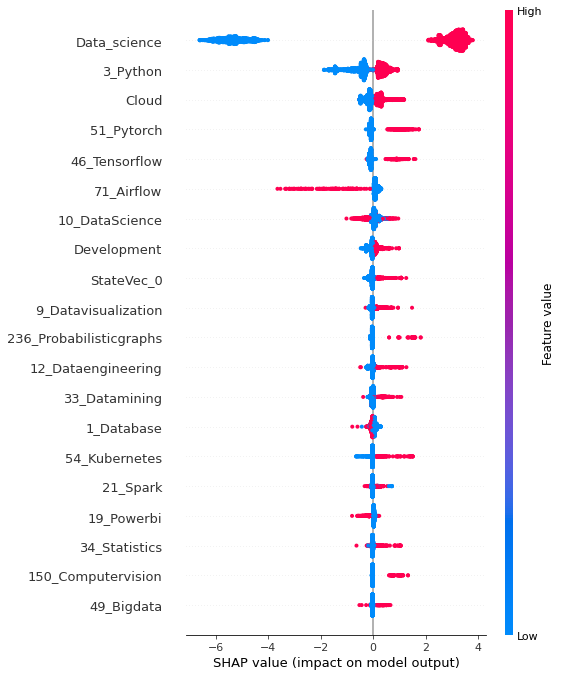

In [16]:

# Get the number of categories
jobLevel_categories = len(jobLevel_indexer_model.labels)
state_categories = len(state_indexer_model.labels)
country_categories = len(country_indexer_model.labels)

feature_names = []

# Add other features that have not been one-hot encoded
feature_names.extend(feature_cols)
# Generate names for each one-hot encoded feature
for feature, size in zip(['JobLevelVec', 'StateVec', 'CountryVec'], 
                         [jobLevel_categories, state_categories, country_categories]):
    feature_names.extend([f"{feature}_{i}" for i in range(size)])
print(feature_names)
# Convert from Spark DataFrame to Pandas DataFrame
pd_train_data = train_data_8.select("features", target_column).toPandas()
pd_test_data = test_data_2.select("features", target_column).toPandas()

# Convert the Vector in the 'features' column to a NumPy array
X_train = np.array(pd_train_data['features'].tolist())
y_train = pd_train_data[target_column].values
X_test = np.array(pd_test_data['features'].tolist())
y_test = pd_test_data[target_column].values
from sklearn.ensemble import GradientBoostingClassifier

# Train a scikit-learn model using parameters similar to those of Spark GBTClassifier
sk_gbt = GradientBoostingClassifier(n_estimators=100, max_depth=10, learning_rate=0.1)
sk_gbt.fit(X_train, y_train)
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(sk_gbt)
shap_values = explainer.shap_values(X_test)

print("Feature names:", feature_names[:10])
print("Sample feature values from X_train:", X_train[0, :10])

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

Top features from SHAP summary: ['Data_science', '3_Python', 'Cloud', '46_Tensorflow', '51_Pytorch', '71_Airflow', '10_DataScience', 'Development', 'StateVec_0', '12_Dataengineering', '33_Datamining', '34_Statistics', '236_Probabilisticgraphs', '5_CloudComputing', '49_Bigdata', '1_Database', '150_Computervision', '95_A/btesting', '54_Kubernetes', '9_Datavisualization']


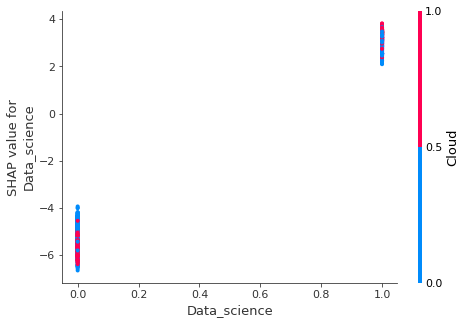

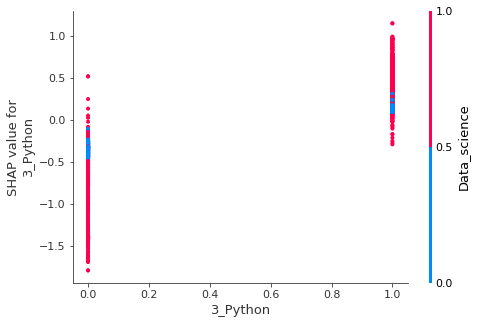

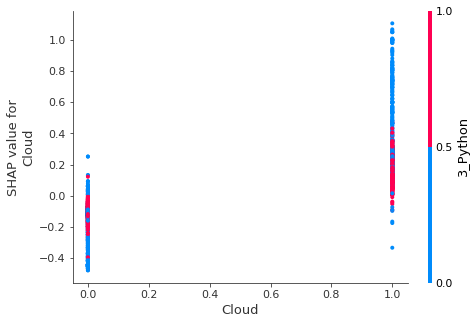

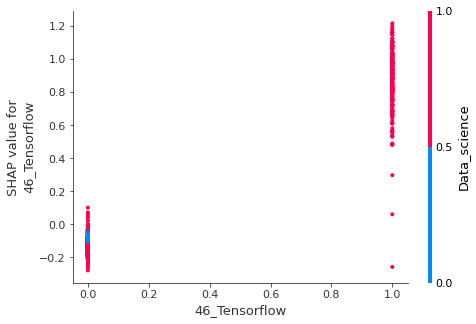

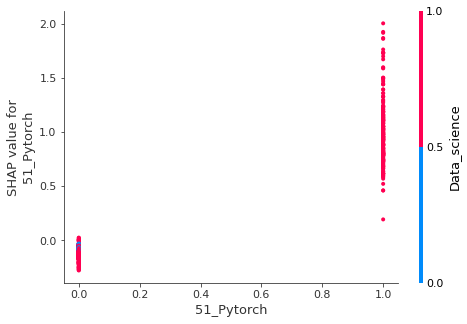

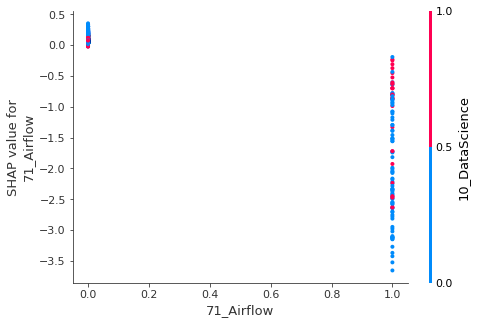

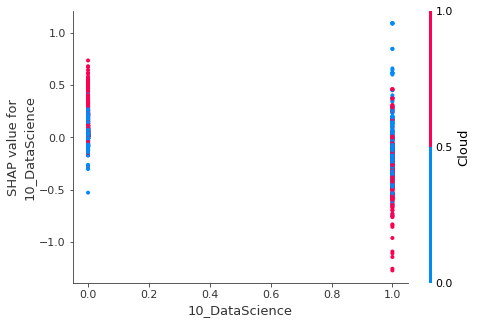

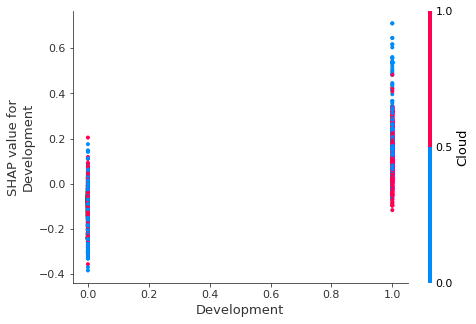

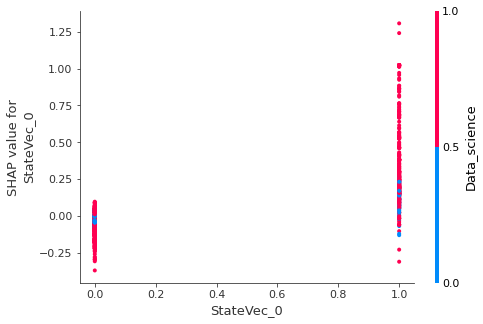

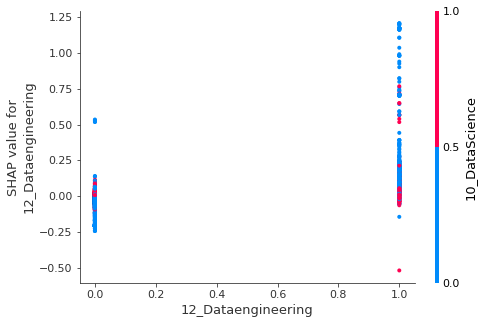

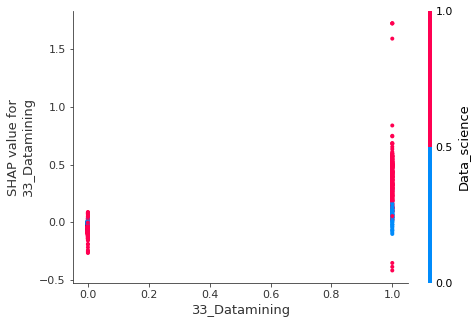

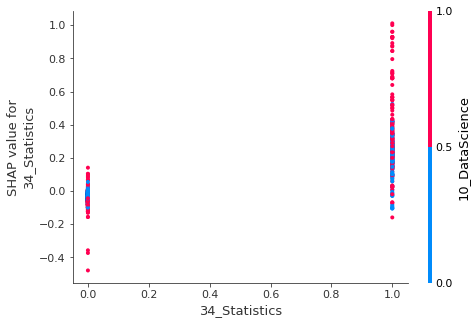

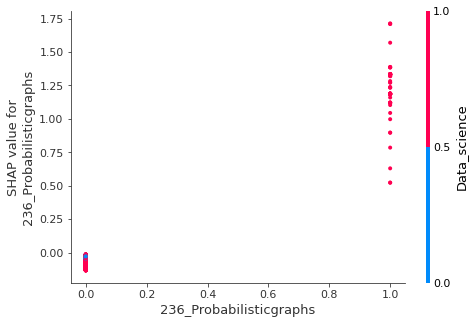

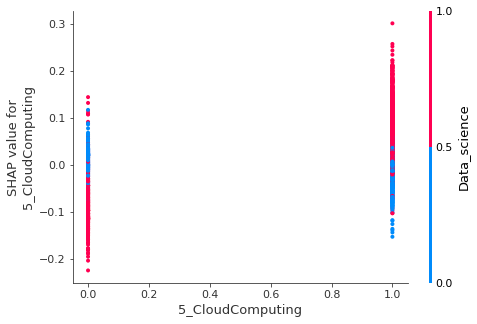

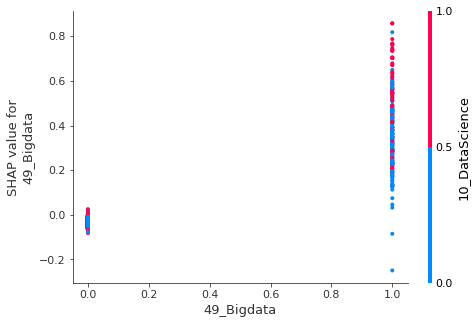

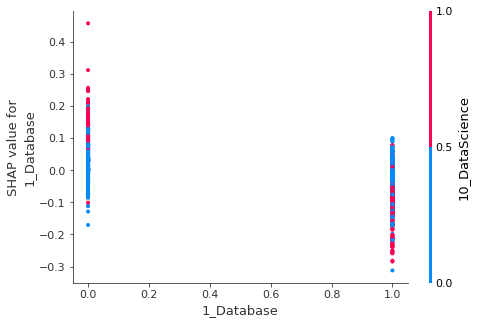

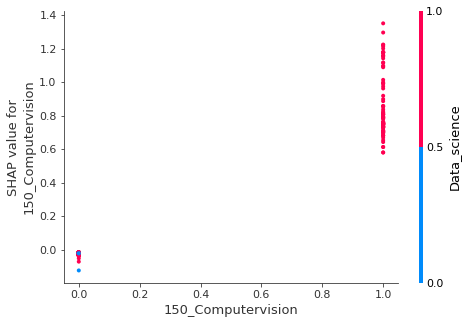

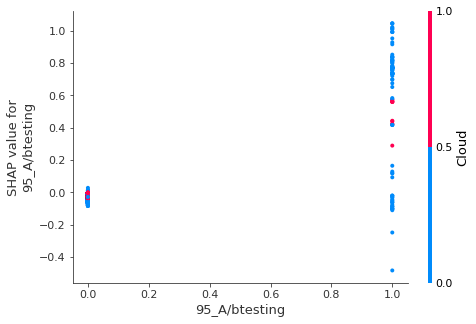

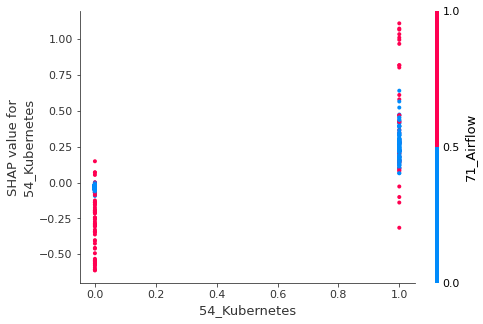

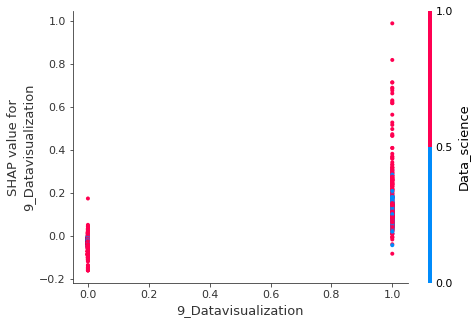

In [17]:
# Extract column names from the SHAP summary plot
top_features = [feature_names[i] for i in np.argsort(np.abs(shap_values).mean(0))[::-1][:20]]
print("Top features from SHAP summary:", top_features)

# Generate SHAP dependence plot for each important feature
for feature in top_features:
    shap.dependence_plot(feature, shap_values, X_test, feature_names=feature_names)

In [19]:
from sklearn.metrics import classification_report, accuracy_score
# Predict on the test sety_pred_test = sk_gbt.predict(X_test)
y_pred_train = sk_gbt.predict(X_train)

# Generate classification reports
report_test = classification_report(y_test, y_pred_test, target_names=['0', '1'])
report_train = classification_report(y_train, y_pred_train, target_names=['0', '1'])

# Calculate accuracy
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)

# Print the reports
print(f"Accuracy on test set: {accuracy_test:.3f}")
print(f"Accuracy on training set: {accuracy_train:.3f}")
print("Classification report on test set:")
print(report_test)
print("Classification report on training set:")
print(report_train)

Accuracy on test set: 0.945
Accuracy on training set: 0.984
Classification report on test set:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1486
           1       0.91      0.99      0.95      1514

    accuracy                           0.95      3000
   macro avg       0.95      0.94      0.95      3000
weighted avg       0.95      0.95      0.95      3000

Classification report on training set:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      6182
           1       0.98      0.99      0.98      6150

    accuracy                           0.98     12332
   macro avg       0.98      0.98      0.98     12332
weighted avg       0.98      0.98      0.98     12332

